<a href="https://colab.research.google.com/github/panimesh14/Deep-Learning-/blob/main/Simple_RNN_and_LSTM_for_simple_sine_wave_modeling_and_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signal/Sine wave generation using Simple RNN and LSTM

In [139]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Data Generation-Sine Wave Generation

In [140]:
x = np.linspace(0,50,501)#Index Variable
y = np.sin(x)#sine wave frequency around 62.5 Hz

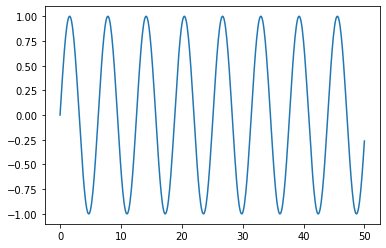

In [141]:
plt.plot(x,y)#sine wave plot

Let's turn this into a DataFrame

In [142]:
df = pd.DataFrame(data=y,index=x,columns=['Sine'])

In [143]:
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


## Splitting Dataset for checking

In [144]:
len(df)

501

In [145]:
test_percent = 0.1 #taking 10% of data as test data

In [146]:
len(df)*test_percent

50.1

In [147]:
test_point = np.round(len(df)*test_percent)

In [148]:
test_ind = int(len(df) - test_point)#index of cut-off point

In [149]:
test_ind

451

In [150]:
train = df.iloc[:test_ind]#Splitting Training Data
test = df.iloc[test_ind:]#Splitting Testing Data

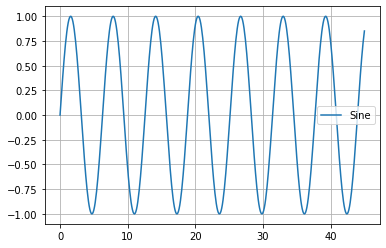

In [151]:
train.plot()
plt.grid()

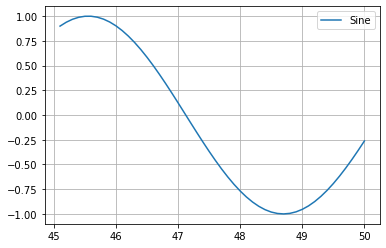

In [152]:
test.plot()
plt.grid()

## Scaling and Normalizing/Transforming Data

In [153]:
from sklearn.preprocessing import MinMaxScaler

In [154]:
scaler = MinMaxScaler()

In [155]:
scaler.fit(train)

MinMaxScaler()

In [156]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [157]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [158]:
scaled_train.shape

(451, 1)

In [159]:
# define sample generator to understand sequence length
length = 2 # Length of extracted sequence required to predict output
batch_size = 1 #Number of batches required for output
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)#contains inputs X and corresponding outputs Y (data,targets,length,batch size)

In [160]:
len(scaled_train)

451

In [161]:
len(generator) # compromises 2 points from total datapoints for prediction of 1st point as from sequence length(length above)

449

In [162]:
X,y = generator[0];
print(f'Given Array sequence: \n{X.flatten()}');
print(f'Predicted y: \n {y}');

Given Array sequence: 
[0.49999912 0.54991622]
Predicted y: 
 [[0.59933458]]


In [163]:
length = 50; #more optimal sequence size for prediction so that the sequence used for prediction captures the trend and/or seasonality
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1);

### Simple RNN Model

In [164]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN

In [165]:
n_features = 1;#number of time varying features to be predicted

In [166]:
#Simple RNN Model Building 
# define model
model = Sequential()

# Simple RNN layer
model.add(SimpleRNN(50,input_shape=(length, n_features)))#50 hidden states and input_shape for each is the length of input vectors per predictionxnumber of features for prediction

# Predictor
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')#Regression Prediction
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [167]:
# Model Fitting
model.fit_generator(generator,epochs=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


401/401 [==============================] - 5s 9ms/step - loss: 0.0032
Epoch 2/5
401/401 [==============================] - 4s 9ms/step - loss: 1.4150e-04
Epoch 3/5
401/401 [==============================] - 4s 9ms/step - loss: 3.3717e-05
Epoch 4/5
401/401 [==============================] - 4s 9ms/step - loss: 2.3237e-04
Epoch 5/5
401/401 [==============================] - 4s 9ms/step - loss: 1.1326e-04


In [168]:
model.history.history.keys()

dict_keys(['loss'])

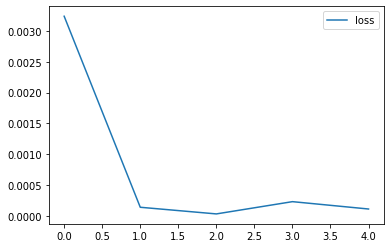

In [169]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Model Prediction and Evaluation

In [170]:
#Demonstration of prediction process for one single item prediction using the sequence from the last elements
first_eval_batch = scaled_train[-length:]#last items of size sequence length
first_eval_batch = first_eval_batch.reshape((1, length, n_features))#reshaping to timeseriesgenwrator dimensions
model.predict(first_eval_batch)#obtaining the first prediction for the sequence

array([[0.9419278]], dtype=float32)

In [171]:
scaled_test[0]#model.predict pretty close to actual 1st test prediction

array([0.94955134])

In [172]:
#Iterative algorithm for updating predictions successively 
test_predictions = []#to store each prediction from iterative updated sequence
first_eval_batch = scaled_train[-length:]#initial sequence for 1st prediction
current_batch = first_eval_batch.reshape((1, length, n_features))#reshaping to generator dimensions for ftting model requirements prediction

for i in range(len(test)):#number of predictions=length of test size
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include new prediction and drop first value to fit to sequence length for generator 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [173]:
test_predictions#predicted scaled test data values

[array([0.9419278], dtype=float32),
 array([0.9575154], dtype=float32),
 array([0.96577597], dtype=float32),
 array([0.9698399], dtype=float32),
 array([0.965973], dtype=float32),
 array([0.9581588], dtype=float32),
 array([0.9433252], dtype=float32),
 array([0.9249808], dtype=float32),
 array([0.9006145], dtype=float32),
 array([0.873015], dtype=float32),
 array([0.8404466], dtype=float32),
 array([0.8043962], dtype=float32),
 array([0.7646439], dtype=float32),
 array([0.7222099], dtype=float32),
 array([0.6770832], dtype=float32),
 array([0.6294443], dtype=float32),
 array([0.5806644], dtype=float32),
 array([0.52963054], dtype=float32),
 array([0.47773424], dtype=float32),
 array([0.4253581], dtype=float32),
 array([0.37275854], dtype=float32),
 array([0.32051232], dtype=float32),
 array([0.26893774], dtype=float32),
 array([0.21911111], dtype=float32),
 array([0.17104538], dtype=float32),
 array([0.12645079], dtype=float32),
 array([0.08392474], dtype=float32),
 array([0.04677426],

In [174]:
scaled_test.flatten()#actual scales test data values

array([9.49551344e-01, 9.69156618e-01, 9.84074225e-01, 9.94155114e-01,
       9.99298559e-01, 9.99453170e-01, 9.94617400e-01, 9.84839568e-01,
       9.70217371e-01, 9.50896908e-01, 9.27071224e-01, 8.98978376e-01,
       8.66899060e-01, 8.31153800e-01, 7.92099752e-01, 7.50127132e-01,
       7.05655314e-01, 6.59128649e-01, 6.11012013e-01, 5.61786173e-01,
       5.11942978e-01, 4.61980443e-01, 4.12397778e-01, 3.63690397e-01,
       3.16344967e-01, 2.70834550e-01, 2.27613868e-01, 1.87114770e-01,
       1.49741909e-01, 1.15868702e-01, 8.58335998e-02, 5.99367021e-02,
       3.84367625e-02, 2.15486014e-02, 9.44095974e-03, 2.23481297e-03,
       2.16257798e-06, 2.76531647e-03, 1.04966661e-02, 2.31189624e-02,
       4.05060876e-02, 6.24843152e-02, 8.88340461e-02, 1.19292002e-01,
       1.53553858e-01, 1.91277281e-01, 2.32085350e-01, 2.75570325e-01,
       3.21297718e-01, 3.68810636e-01])

## Inverse Transformations and Comparison

In [175]:
true_predictions = scaler.inverse_transform(test_predictions)#back to non-normalized scale

In [176]:
true_predictions.flatten()

array([ 0.88385026,  0.91502526,  0.93154623,  0.93967397,  0.93194033,
        0.916312  ,  0.8866451 ,  0.84995659,  0.80122434,  0.74602575,
        0.68088949,  0.60878931,  0.52928534,  0.44441794,  0.35416531,
        0.25888829,  0.16132927,  0.05926238, -0.0445294 , -0.14928086,
       -0.25447911, -0.3589707 , -0.46211905, -0.56177149, -0.6579022 ,
       -0.74709065, -0.83214207, -0.90644244, -0.97307289, -1.0269347 ,
       -1.07185403, -1.10277974, -1.12278588, -1.12861113, -1.12186777,
       -1.1022729 , -1.06981662, -1.02775401, -0.97216532, -0.9090387 ,
       -0.83368871, -0.75422001, -0.66450786, -0.57408759, -0.47585847,
       -0.37702433, -0.27511271, -0.17416041, -0.07384404,  0.02608694])

In [177]:
test.transpose()

,45.1,45.2,45.3,45.4,45.5,45.6,45.7,45.8,45.9,46.0,...,49.1,49.2,49.3,49.4,49.5,49.6,49.7,49.8,49.9,50.0
Sine,0.899097,0.938307,0.968142,0.988304,0.998591,0.9989,0.989229,0.969673,0.940429,0.901788,...,-0.918979,-0.875023,-0.822324,-0.761408,-0.692885,-0.617439,-0.535823,-0.448854,-0.3574,-0.262375


In [178]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [179]:
test.T

,45.1,45.2,45.3,45.4,45.5,45.6,45.7,45.8,45.9,46.0,...,49.1,49.2,49.3,49.4,49.5,49.6,49.7,49.8,49.9,50.0
Sine,0.899097,0.938307,0.968142,0.988304,0.998591,0.998900,0.989229,0.969673,0.940429,0.901788,...,-0.918979,-0.875023,-0.822324,-0.761408,-0.692885,-0.617439,-0.535823,-0.448854,-0.357400,-0.262375
Predictions,0.883850,0.915025,0.931546,0.939674,0.931940,0.916312,0.886645,0.849957,0.801224,0.746026,...,-0.833689,-0.754220,-0.664508,-0.574088,-0.475858,-0.377024,-0.275113,-0.174160,-0.073844,0.026087


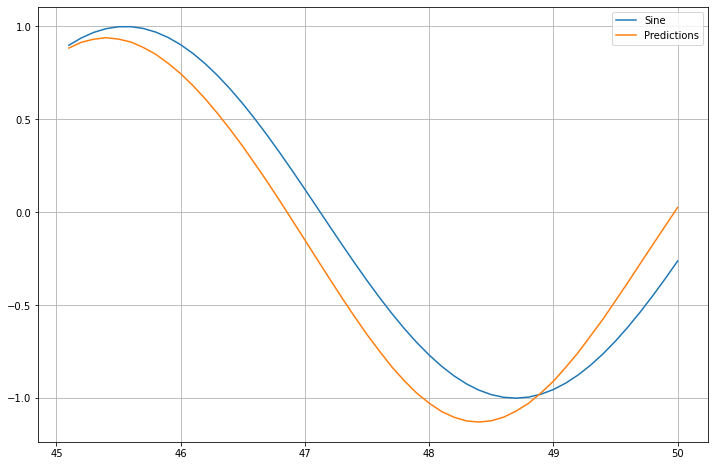

In [180]:

#Simple/Vanilla RNN prediction
test.plot(figsize=(12,8))
plt.grid()
#predictions somewhat closely match the sine wave

## Early Stopping and Validation Generator for Optimization over Epochs

In [181]:
from tensorflow.keras.callbacks import EarlyStopping

In [182]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [183]:
length = 49#for total prediction of length 50 sequence size must be less than or equal to 50
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)


validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length,batch_size=1)

# LSTM Model

In [184]:

#LSTM model building
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(50,input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [185]:
model.fit_generator(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


402/402 [==============================] - 11s 21ms/step - loss: 0.0165 - val_loss: 1.2145e-04
Epoch 2/20
402/402 [==============================] - 8s 20ms/step - loss: 1.8367e-04 - val_loss: 6.4430e-05
Epoch 3/20
402/402 [==============================] - 8s 19ms/step - loss: 1.1524e-04 - val_loss: 2.1018e-05
Epoch 4/20
402/402 [==============================] - 8s 19ms/step - loss: 8.5373e-05 - val_loss: 2.2994e-05
Epoch 5/20
402/402 [==============================] - 8s 19ms/step - loss: 4.4696e-04 - val_loss: 1.3819e-06
Epoch 6/20
402/402 [==============================] - 8s 20ms/step - loss: 7.0609e-05 - val_loss: 2.4064e-05
Epoch 7/20
402/402 [==============================] - 8s 20ms/step - loss: 3.2394e-05 - val_loss: 7.1891e-06


In [186]:

#LSTM Model Predictions
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


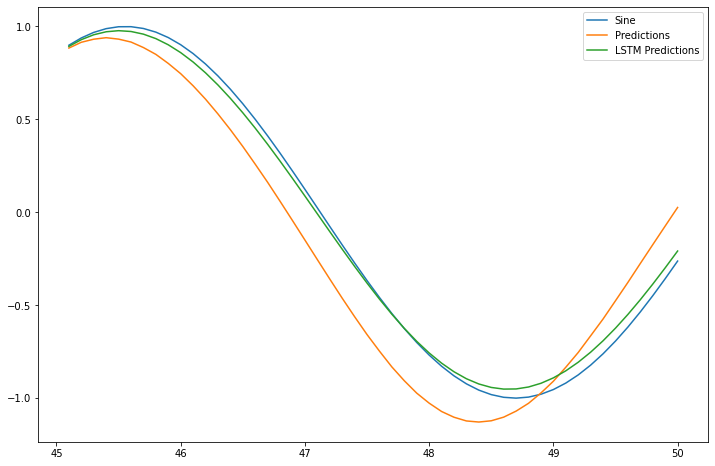

In [187]:
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))

# Forecasting

In [188]:
#full dataset used here
#Scaling and Normalizing on full dataset
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [189]:
length = 50 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [190]:

#Model Building for LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=6)

Epoch 1/6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


451/451 [==============================] - 11s 21ms/step - loss: 0.0146
Epoch 2/6
451/451 [==============================] - 9s 20ms/step - loss: 1.4070e-04
Epoch 3/6
451/451 [==============================] - 9s 20ms/step - loss: 1.0488e-04
Epoch 4/6
451/451 [==============================] - 9s 19ms/step - loss: 2.4406e-04
Epoch 5/6
451/451 [==============================] - 9s 20ms/step - loss: 1.6211e-04
Epoch 6/6
451/451 [==============================] - 9s 20ms/step - loss: 9.3794e-05


In [191]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction from model for one time step ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [192]:
forecast = scaler.inverse_transform(forecast)

In [193]:
# forecast
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [194]:
len(forecast)

50

In [195]:
50*0.1#since sampling period is 0.1s (500 samples for 50s))

5.0

In [196]:
forecast_index = np.arange(50.1,55.1,step=0.1)

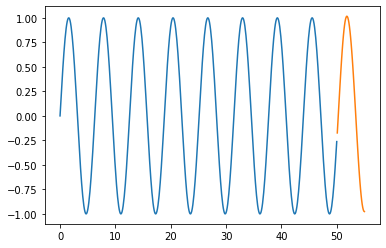

In [197]:
plt.plot(df.index,df['Sine'])
plt.plot(forecast_index,forecast)
#prediction from LSTM model matches the overall trend well

In [198]:
len(forecast_index)

50